# CIFAR-10 Task with ResNet

In [1]:
from ay_torch import *
%matplotlib widget

In [2]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=torchvision.transforms.ToTensor(),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=torchvision.transforms.ToTensor(),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1],dset_train.classes[dset_train[0][1]])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1],dset_test.classes[dset_test[0][1]])

dset_train size: 50000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 32, 32])
dset_train[0] label value: 6 frog
dset_train[0][0] value range: tensor(0.) tensor(1.)
dset_test size: 10000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 32, 32])
dset_test[0] label value: 3 cat


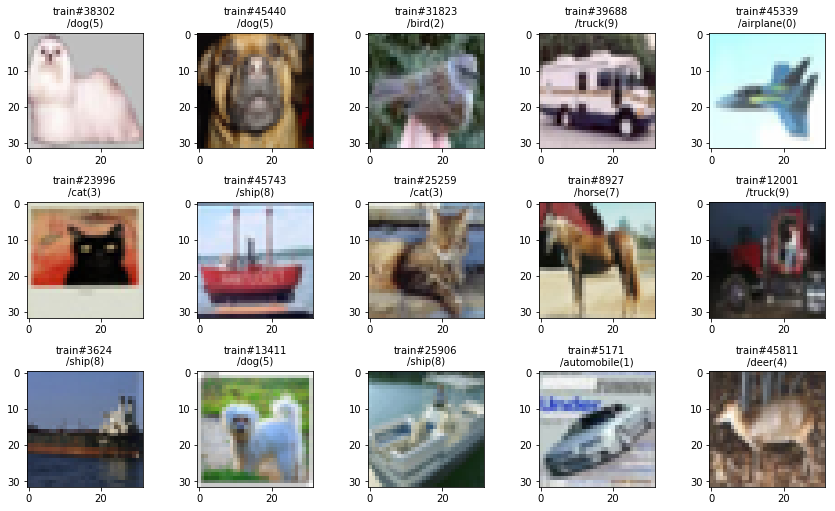

In [4]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

In [106]:
'''
Create a convolutional layer optionally with ReLu and normalization layers.
Ref. https://github.com/fastai/fastai/tree/master/fastai/layers.py
'''
def ConvLayer(in_channels, out_channels, kernel_size, stride=1, padding=None,
              bias=None, ndim=2, norm_type='batch', bn_1st=True,
              activation=torch.nn.ReLU, transpose=False, init='auto', bias_std=0.01, **kwargs):
  if padding is None: padding= ((kernel_size-1)//2 if not transpose else 0)
  bn= norm_type in ('batch', 'batch_zero')
  inn= norm_type in ('instance', 'instance_zero')
  if bias is None: bias= not (bn or inn)
  conv_func= getattr(torch.nn, f'Conv{"Transpose" if transpose else ""}{ndim}d')
  conv= conv_func(in_channels, out_channels, kernel_size=kernel_size, 
                  stride=stride, padding=padding, bias=bias, **kwargs)
  act= None if activation is None else activation()
  if getattr(conv,'bias',None) is not None and bias_std is not None:
    if bias_std!=0: torch.nn.init.normal_(conv.bias, 0.0, bias_std)
    else: conv.bias.data.zero_()
  f_init= None
  if act is not None and init=='auto':
    if hasattr(act.__class__, '__default_init__'):
      f_init= act.__class__.__default_init__
    else:  f_init= getattr(act, '__default_init__', None)
  if f_init is not None: f_init(conv.weight)
  if   norm_type=='weight':   conv= torch.nn.utils.weight_norm(conv)
  elif norm_type=='spectral': conv= torch.nn.utils.spectral_norm(conv)
  layers= [conv]
  act_bn= []
  if act is not None: act_bn.append(act)
  if bn: 
    bnl= getattr(torch.nn, f'BatchNorm{ndim}d')(out_channels)
    if bnl.affine:
      bnl.bias.data.fill_(1e-3)
      bnl.weight.data.fill_(0. if norm_type=='batch_zero' else 1.)
    act_bn.append(bnl)
  if inn: 
    innl= getattr(torch.nn, f'InstanceNorm{ndim}d')(out_channels, affine=True)
    if innl.affine:
      innl.bias.data.fill_(1e-3)
      innl.weight.data.fill_(0. if norm_type=='instance_zero' else 1.)
    act_bn.append(innl)
  if bn_1st: act_bn.reverse()
  layers+= act_bn
  return torch.nn.Sequential(*layers)

def res_conv_block(ni, nf, kernel_size, stride, bottleneck):
  if not bottleneck:
    return torch.nn.Sequential(
          ConvLayer(ni, nf, kernel_size=kernel_size, stride=stride),
          ConvLayer(nf, nf, kernel_size=kernel_size, activation=None, norm_type='batch_zero'))
  else:
    return torch.nn.Sequential(
          ConvLayer(ni, nf//4, kernel_size=1),
          ConvLayer(nf//4, nf//4, kernel_size=kernel_size, stride=stride),
          ConvLayer(nf//4, nf, kernel_size=1, activation=None, norm_type='batch_zero'))

def noop(x):  return x

class TResBlock(torch.nn.Module):
  def __init__(self, ni, nf, kernel_size=3, stride=1, bottleneck=False):
    super(TResBlock,self).__init__()
    self.convs= res_conv_block(ni, nf, kernel_size, stride, bottleneck)
    self.idconv= noop if ni==nf else ConvLayer(ni, nf, kernel_size=1, activation=None)
    self.pool= noop if stride==1 else torch.nn.AvgPool2d(2, ceil_mode=True)
  def forward(self, x):
    return torch.nn.functional.relu(self.convs(x) + self.idconv(self.pool(x)))

class TResNet(torch.nn.Module):
  def __init__(self, n_classes, bottleneck=False):
    super(TResNet,self).__init__()
    self.net= torch.nn.Sequential(
          TResBlock(3, 16, kernel_size=3, bottleneck=bottleneck),
          TResBlock(16, 32, kernel_size=3, bottleneck=bottleneck),
          TResBlock(32, 64, kernel_size=3, bottleneck=bottleneck),
          TResBlock(64, 128, kernel_size=3, bottleneck=bottleneck),
          TResBlock(128, 256, kernel_size=3, bottleneck=bottleneck),
          torch.nn.AdaptiveAvgPool2d(1),
          torch.nn.Flatten(),
          torch.nn.Linear(256, n_classes)
          )
  def forward(self, x):
    return self.net(x)

def res_stem(*sizes):
  return [
      ConvLayer(sizes[i], sizes[i+1], kernel_size=3, stride=2 if i==0 else 1)
        for i in range(len(sizes)-1)
      ] + [torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

class TResNet2(torch.nn.Sequential):
  def __init__(self, n_classes, layers, expansion=1, bottleneck=False):
    stem= res_stem(3,32,32,64)
    self.block_sizes= [64, 64, 128, 256, 512]
    for i in range(1,5): self.block_sizes[i]*= expansion
    self.bottleneck= bottleneck
    blocks= [self.make_layer(*o) for o in enumerate(layers)]
    super(TResNet2,self).__init__(*stem, *blocks,
                                  torch.nn.AdaptiveAvgPool2d(1),
                                  torch.nn.Flatten(),
                                  torch.nn.Linear(self.block_sizes[-1], n_classes))
  def make_layer(self, idx, n_layers):
    stride= 1 if idx==0 else 2
    ch_in,ch_out= self.block_sizes[idx:idx+2]
    return torch.nn.Sequential(*[
          TResBlock(ch_in if i==0 else ch_out, ch_out, kernel_size=3, stride=stride if i==0 else 1, bottleneck=self.bottleneck)
          for i in range(n_layers)])

class TSimpleCNN(torch.nn.Module):
  def __init__(self, n_classes):
    super(TSimpleCNN,self).__init__()
    self.net= torch.nn.Sequential(
          ConvLayer(3, 16, kernel_size=3),
          ConvLayer(16, 32, kernel_size=3),
          ConvLayer(32, 64, kernel_size=3),
          ConvLayer(64, 128, kernel_size=3),
          ConvLayer(128, 256, kernel_size=3),
          torch.nn.AdaptiveAvgPool2d(1),
          torch.nn.Flatten(),
          torch.nn.Linear(256, n_classes)
          )
  def forward(self, x):
    return self.net(x)

class TSimpleCNN2(torch.nn.Module):
  def __init__(self, n_classes):
    super(TSimpleCNN2,self).__init__()
    self.net= torch.nn.Sequential(
          ConvLayer(3, 8, kernel_size=5),
          ConvLayer(8, 16, kernel_size=3),
          ConvLayer(16, 32, kernel_size=3),
          ConvLayer(32, 64, kernel_size=3),
          ConvLayer(64, 100, kernel_size=3, activation=None),
          torch.nn.AdaptiveAvgPool2d(1),
          torch.nn.Flatten(),
          torch.nn.Linear(100, n_classes)
          )
  def forward(self, x):
    return self.net(x)

In [171]:
#Setup a neural network.
# net= TSimpleCNN(n_classes=len(dset_train.classes))
net= TResNet(n_classes=len(dset_train.classes), bottleneck=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [172]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 32, 32)


Layer (type:depth-idx)                        Output Shape              Param #
TResNet                                       --                        --
├─Sequential: 1-1                             [1, 10]                   --
│    └─TResBlock: 2-1                         [1, 16, 32, 32]           --
│    │    └─Sequential: 3-1                   [1, 16, 32, 32]           2,800
│    │    └─Sequential: 3-2                   [1, 16, 32, 32]           80
│    └─TResBlock: 2-2                         [1, 32, 32, 32]           --
│    │    └─Sequential: 3-3                   [1, 32, 32, 32]           13,952
│    │    └─Sequential: 3-4                   [1, 32, 32, 32]           576
│    └─TResBlock: 2-3                         [1, 64, 32, 32]           --
│    │    └─Sequential: 3-5                   [1, 64, 32, 32]           55,552
│    │    └─Sequential: 3-6                   [1, 64, 32, 32]           2,176
│    └─TResBlock: 2-4                         [1, 128, 32, 32]          --
│    

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


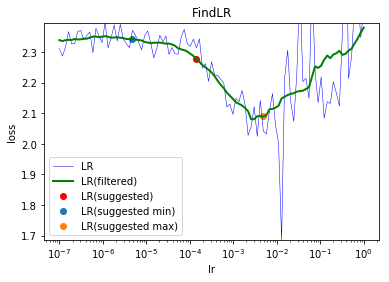

lr= 0.00014125375446227543, lr_min=4.7863009232263826e-06, lr_max=0.0048977881936844644


In [173]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	0.23279472	0.88185875	0.73626592	33.291220
1	0.36563148	0.55950068	0.81180334	33.351704
2	0.26160300	0.50741750	0.84096338	33.272552
3	0.14245996	0.44557163	0.86216162	33.308316
4	0.07251861	0.42543224	0.86853105	33.159312


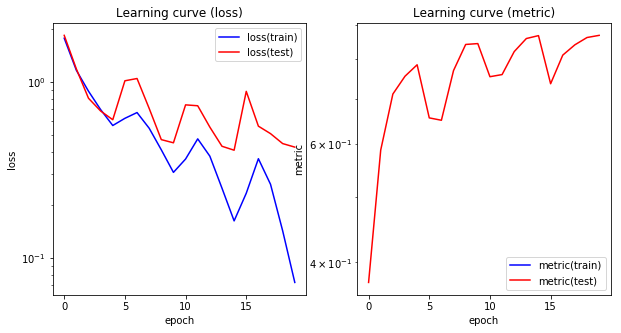

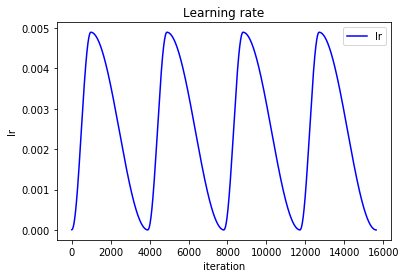

In [177]:
FitOneCycle(net, n_epoch=5, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

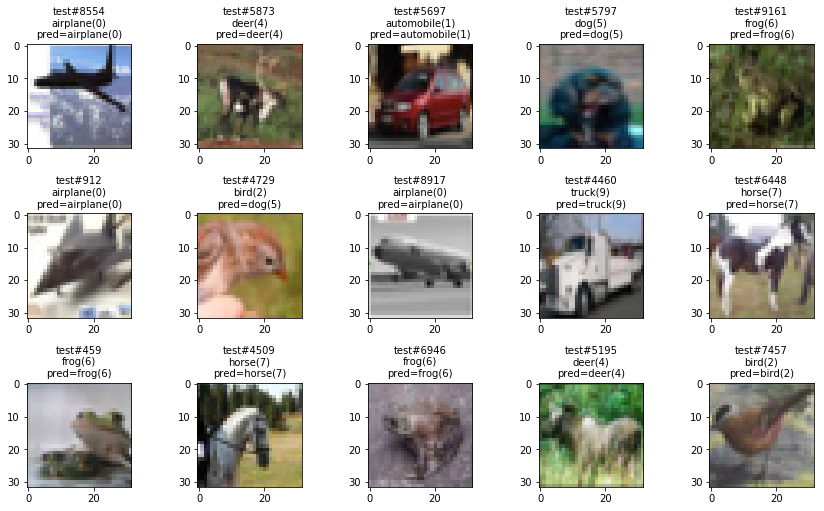

In [125]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

-----------

In [126]:
#Setup a neural network.
# net= TResNet2(n_classes=len(dset_train.classes), layers=[2,2,2,2])  #ResNet-18
net= TResNet2(n_classes=len(dset_train.classes), layers=[2,2,2,2], bottleneck=True)  #ResNet-18+

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [127]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 32, 32)


Layer (type:depth-idx)                        Output Shape              Param #
TResNet2                                      --                        --
├─Sequential: 1-1                             [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                            [1, 32, 16, 16]           864
│    └─BatchNorm2d: 2-2                       [1, 32, 16, 16]           64
│    └─ReLU: 2-3                              [1, 32, 16, 16]           --
├─Sequential: 1-2                             [1, 32, 16, 16]           --
│    └─Conv2d: 2-4                            [1, 32, 16, 16]           9,216
│    └─BatchNorm2d: 2-5                       [1, 32, 16, 16]           64
│    └─ReLU: 2-6                              [1, 32, 16, 16]           --
├─Sequential: 1-3                             [1, 64, 16, 16]           --
│    └─Conv2d: 2-7                            [1, 64, 16, 16]           18,432
│    └─BatchNorm2d: 2-8                       [1, 64, 16, 16]           128
│    └─ReLU

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


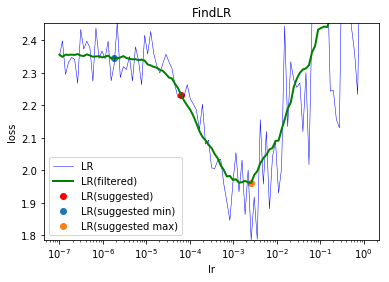

lr= 6.309573444801935e-05, lr_min=1.8197008586099832e-06, lr_max=0.0025703957827688637


In [128]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	0.17814348	0.87965274	0.74910430	20.833961
1	0.22086229	0.82551450	0.78841561	20.916689
2	0.06434030	0.85008953	0.79498408	21.039015


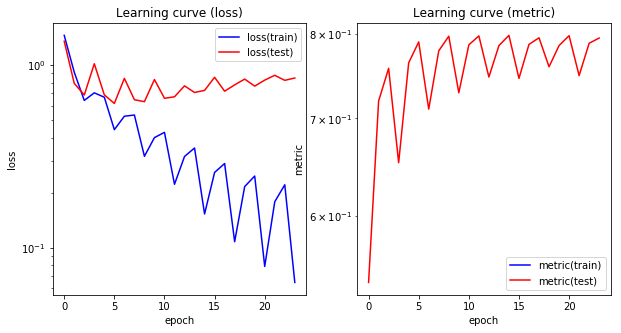

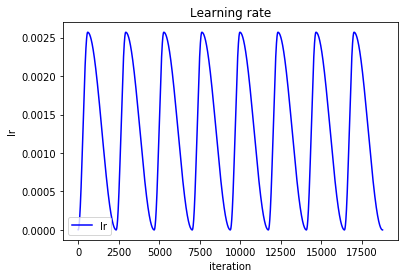

In [136]:
FitOneCycle(net, n_epoch=3, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

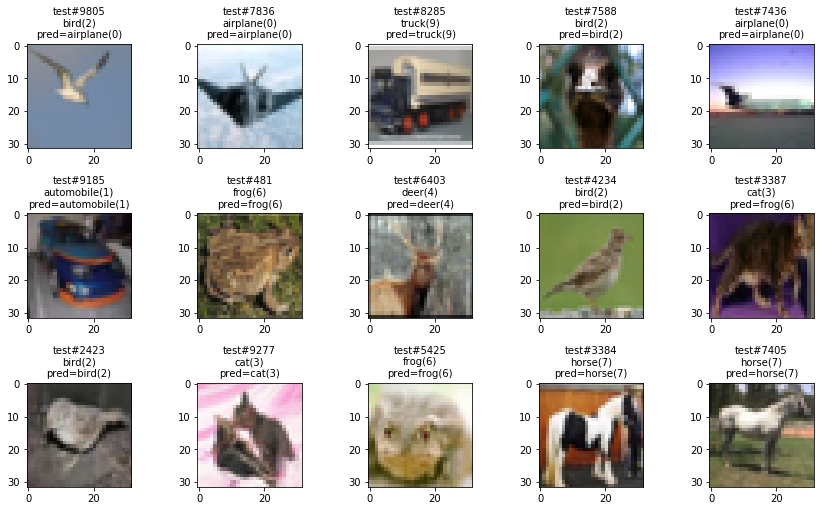

In [65]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)